In [1]:
# data analysis
import numpy as np
import pandas as pd
import sys
import glob
import os,time

from imp import reload
import coronadataclass as cdc; reload(cdc)

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]


In [2]:
data = cdc.CoronaData()




def LMSQ(x,y):
    n   = len(x)
    sx  = np.sum(x)
    sy  = np.sum(y)
    sxx = np.dot(x,x)
    sxy = np.dot(x,y)
    syy = np.dot(y,y)
    
    denom  = (n*sxx - sx*sx) * 1.
    b      = (n*sxy - sx*sy)/denom
    a      = (sy - b*sx)/n
    estim  = np.array([a,b], dtype = np.float)

    sigma2 = syy + n*a*a + b*b*sxx + 2*a*b*sx - 2*a*sy - 2*b*sxy
    cov    = sigma2 / denom * np.array([[sxx,-sx],[-sx,n]], dtype = np.float)

    return estim,cov



colornames       = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]




-0.008513622640559227 1.3844823723788726


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


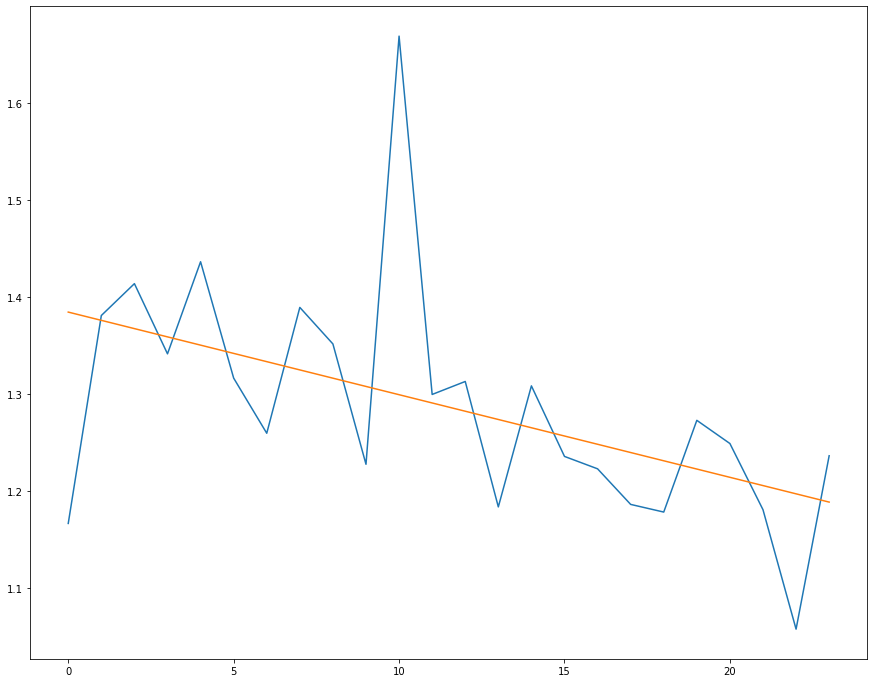

In [3]:
ca = np.array(data.Austria['Confirmed'])

increaserate = (ca[1:]/ca[:-1])[40:]

x = np.arange(len(increaserate))

(b,a), cov = LMSQ(x,increaserate)

print(a,b)


plt.plot(increaserate)
plt.plot(x,a*x+b)
plt.show()

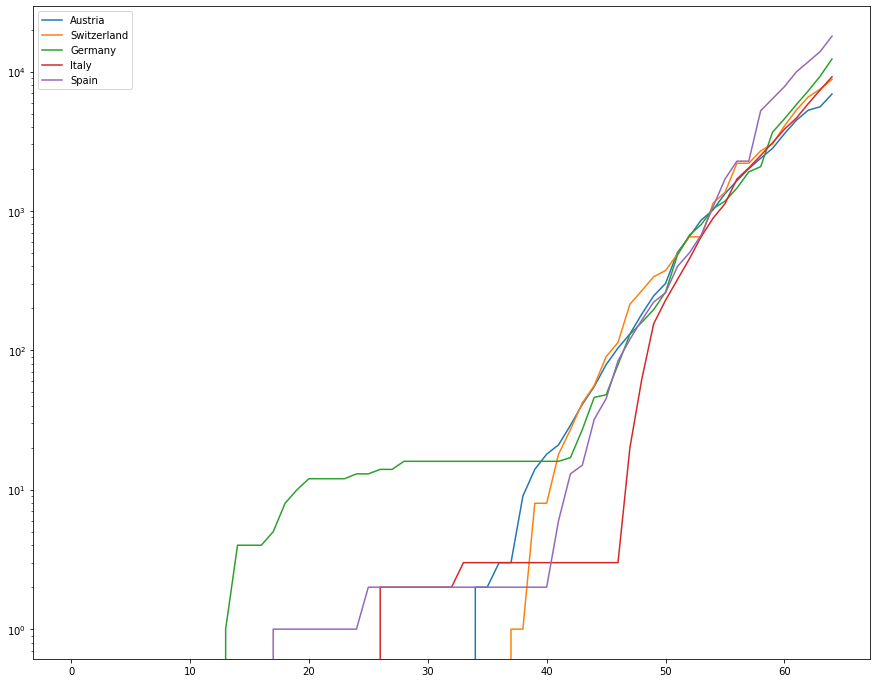

In [4]:
plt.plot(data.Austria    ['Confirmed'],           label = 'Austria')
plt.plot(data.Switzerland['Confirmed'].shift( 3), label = 'Switzerland')
plt.plot(data.Germany    ['Confirmed'].shift( 8), label = 'Germany')
plt.plot(data.Italy      ['Confirmed'].shift(17), label = 'Italy')
plt.plot(data.Spain      ['Confirmed'].shift( 7), label = 'Spain')
plt.legend()
plt.yscale('log')
plt.show()

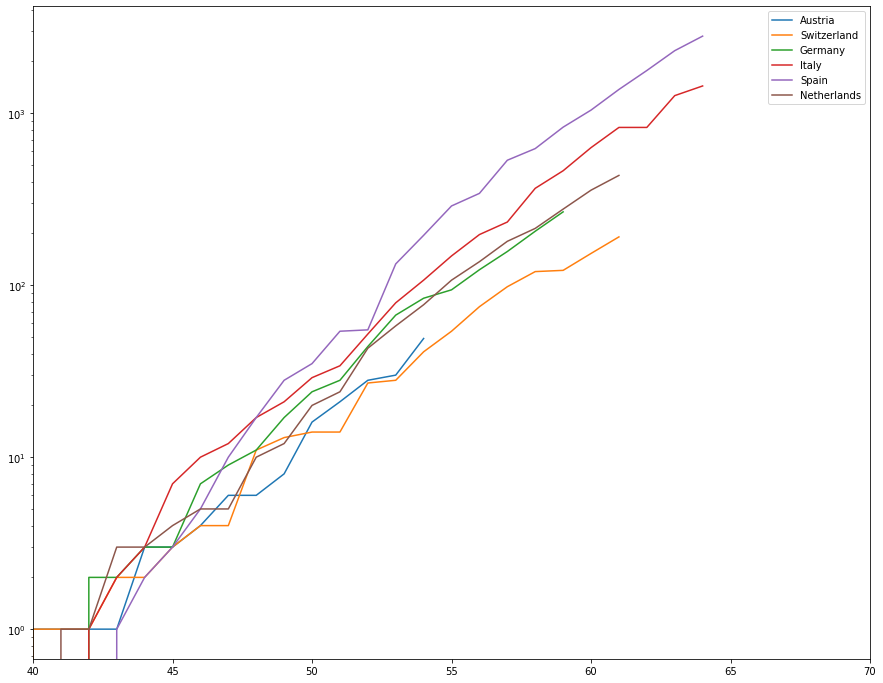

In [5]:
plt.plot(data.Austria    ['Deaths'].shift(-10), label = 'Austria')
plt.plot(data.Switzerland['Deaths'].shift(- 3), label = 'Switzerland')
plt.plot(data.Germany    ['Deaths'].shift(- 5), label = 'Germany')
plt.plot(data.Italy      ['Deaths'].shift( 12), label = 'Italy')
plt.plot(data.Spain      ['Deaths'].shift(  2), label = 'Spain')
plt.plot(data.Netherlands['Deaths'].shift(- 3), label = 'Netherlands')
plt.legend()
plt.yscale('log')
plt.xlim([40,70])
plt.show()

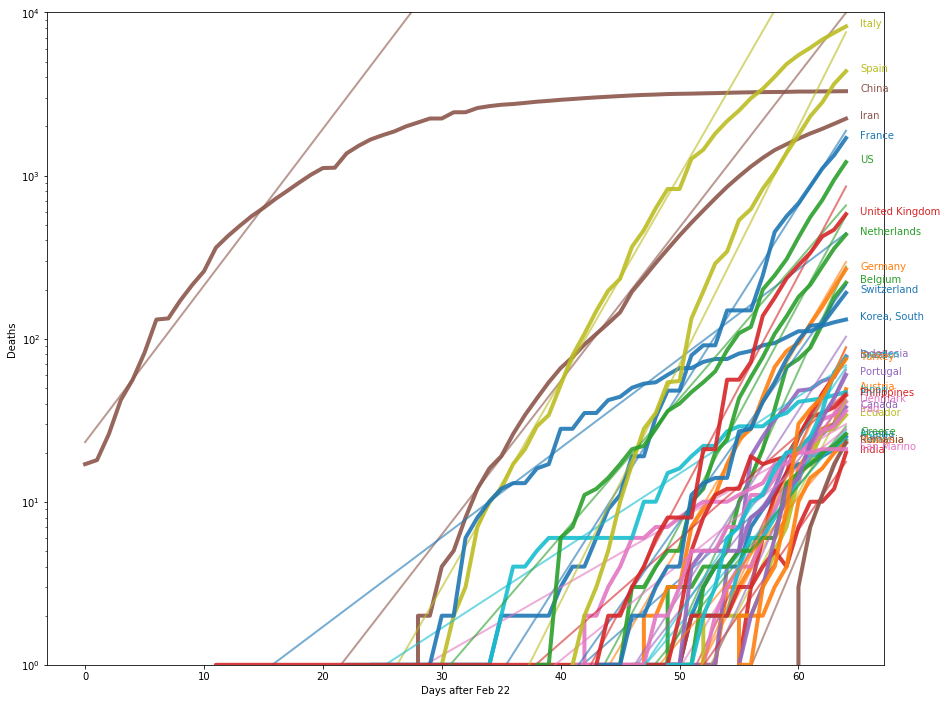

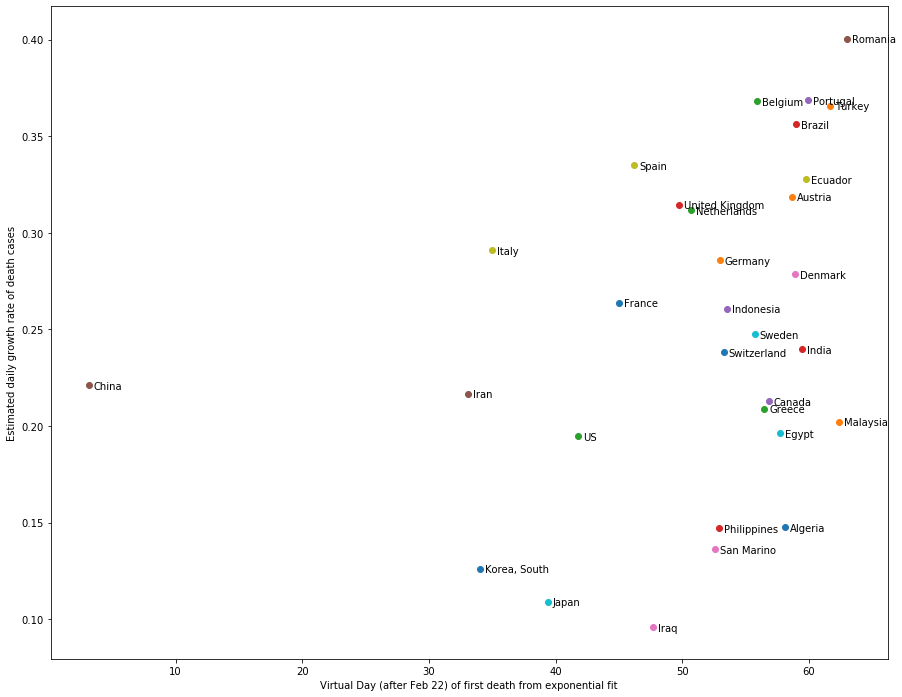

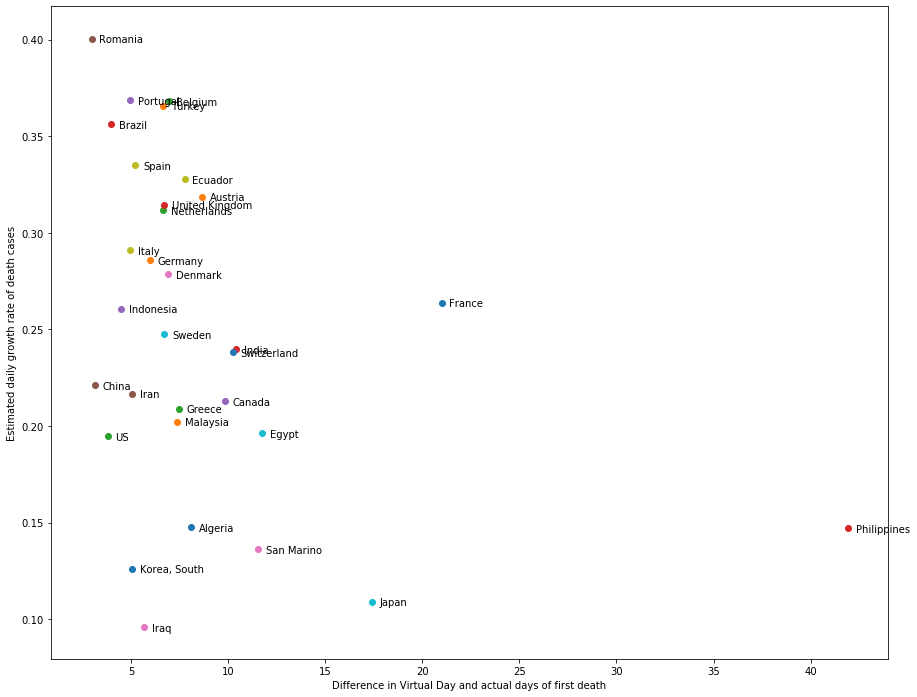

In [6]:
# fit exponential growth of cumulative deaths
# start at 'dthr_fit' cases and continue for 'maxdays' days
# only consider countries with more culumative deaths than 'dthr'

dthr      = 20
dthr_fit  = 5
maxdays   = 20

fig1,ax1  = plt.subplots()
fig2,ax2  = plt.subplots()
fig3,ax3  = plt.subplots()
i         = 0

for country, countrydata in data:
    d = np.array(countrydata['Deaths'])
    if d[-1] >= dthr:
        firstcase = np.min(np.where(d >= 1))
        startfit  = np.min(np.where(d >= dthr_fit))

        x = np.arange(len(d[startfit:min(len(d),startfit+maxdays)]))
        y = np.log(d[startfit:min(len(d),startfit+maxdays)])
        
        if len(y) > 1:
            estim, cov = LMSQ(x,y)
            
            offset2     = np.array([startfit + .4, -.002])
            ax2.scatter(estim[0] + startfit, estim[1],label = country, c = colornames[i % len(colornames)])
            ax2.annotate(country,estim + offset2)

            xx = np.arange(len(data))
            ax1.plot(xx,d, c = colornames[i % len(colornames)], lw = 4, alpha = .9)
            ax1.plot(xx,np.exp(estim[0] + estim[1] * (xx-startfit)), c = colornames[i % len(colornames)], lw = 2, alpha = .6)
            ax1.annotate(country, np.array([len(data)+.2,d[-1]]), c = colornames[i%len(colornames)])
            
            offset3     = np.array([startfit + .4 - firstcase, -.002])
            ax3.scatter(estim[0] + startfit - firstcase, estim[1], label = country, c = colornames[i % len(colornames)])
            ax3.annotate(country,estim + offset3)
            
            i += 1
            
ax1.set_xlabel(r'Days after Feb 22')
ax1.set_ylabel(r'Deaths')
ax1.set_yscale('log')        
ax1.set_ylim([1e0,1e4])
ax2.set_ylabel(r'Estimated daily growth rate of death cases')
ax2.set_xlabel(r'Virtual Day (after Feb 22) of first death from exponential fit')
ax3.set_ylabel(r'Estimated daily growth rate of death cases')
ax3.set_xlabel(r'Difference in Virtual Day and actual days of first death')
plt.show()


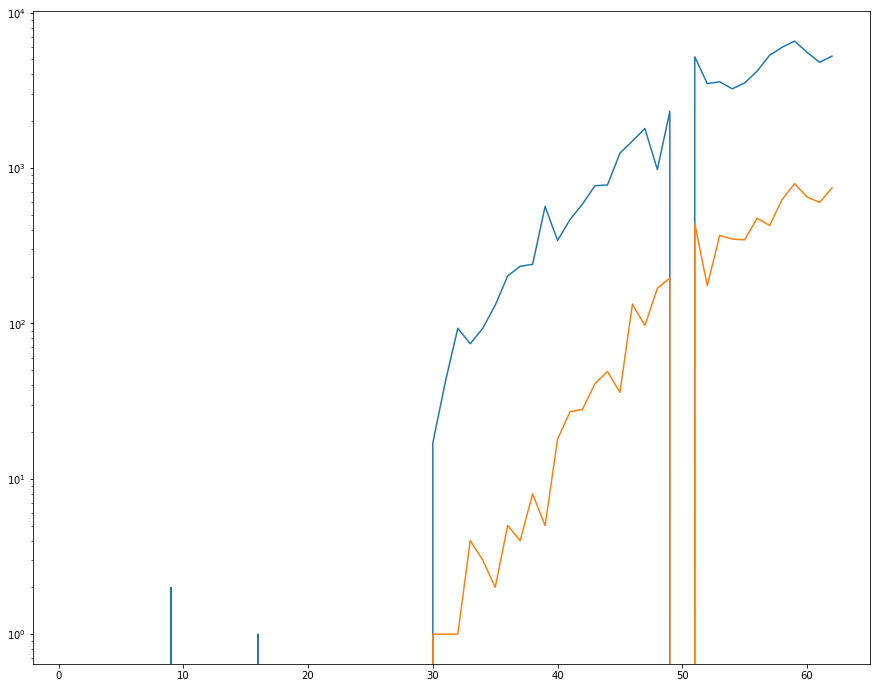

In [11]:
plt.plot(data.Italy['Confirmed']-data.Italy['Confirmed'].shift())
plt.plot(data.Italy['Deaths']-data.Italy['Deaths'].shift())
plt.yscale('log')